<a href="https://colab.research.google.com/github/candanbayar/2022352_ID_Wordle_Twitter_Dataset_/blob/main/Big_Data_Wordle_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [1]:
# pyspark 

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=88a6490b94b056667a4e06f27b605639e207e6ec2a510b546eb43d74f91e907b
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
!pip install -U textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [4]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt   
from itertools import cycle
import re 

# import libraries about NLP 
import warnings
warnings.simplefilter("ignore")

import re
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import gensim  
import nltk 
from nltk.sentiment import SentimentIntensityAnalyzer 
from textblob import TextBlob 
from wordcloud import WordCloud, STOPWORDS 

from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf
import plotly.express as px 

# Modelling 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# import keras 

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [5]:
# import pyspark

from pyspark.sql import SparkSession

In [6]:
# create variable called spark 

spark = SparkSession.builder.appName('wordle_tweet').getOrCreate()

In [7]:
# spark 

spark

In [8]:
tw = spark.read.csv("tweets_wordle.csv")

In [9]:
tw

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string]

In [10]:
# read the dataset 

spark.read.option('header','true').csv('tweets_wordle.csv').show()

+-----------+-------------------+--------------------+--------------+--------------+
|  wordle_id|           tweet_id|          tweet_date|tweet_username|    tweet_text|
+-----------+-------------------+--------------------+--------------+--------------+
|        210|1482553374591660037|2022-01-16 03:20:...|      bpszebes|Wordle 210 4/6|
|    ⬛⬛🟨🟨⬛|               null|                null|          null|          null|
|     🟩⬛⬛⬛⬛|               null|                null|          null|          null|
|   🟩🟩🟨⬛⬛|               null|                null|          null|          null|
|🟩🟩🟩🟩🟩"|               null|                null|          null|          null|
|        210|1482553387937898499|2022-01-16 03:20:...|    cruisecoup|Wordle 210 4/6|
|      ⬜⬜⬜⬜⬜|               null|                null|          null|          null|
|  🟩🟩🟨🟨⬜|               null|                null|          null|          null|
|  🟩🟩⬜🟩🟨|               null|                null|          null|          null|

In [11]:
# type dataset 
type(tw)

pyspark.sql.dataframe.DataFrame

In [12]:
# check the schema 

tw.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)



In [13]:
# read dataset 

tw = pd.read_csv("tweets_wordle.csv")

In [14]:
tw.dtypes

wordle_id          int64
tweet_id           int64
tweet_date        object
tweet_username    object
tweet_text        object
dtype: object

In [15]:
tw.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩


# Word Cloud

In [16]:
# word cloud 

#Make a word Cloud from dataset
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [17]:
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=40, max_words=700,background_color="#002210").generate(text)
    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.style.use('ggplot')
    plt.show()

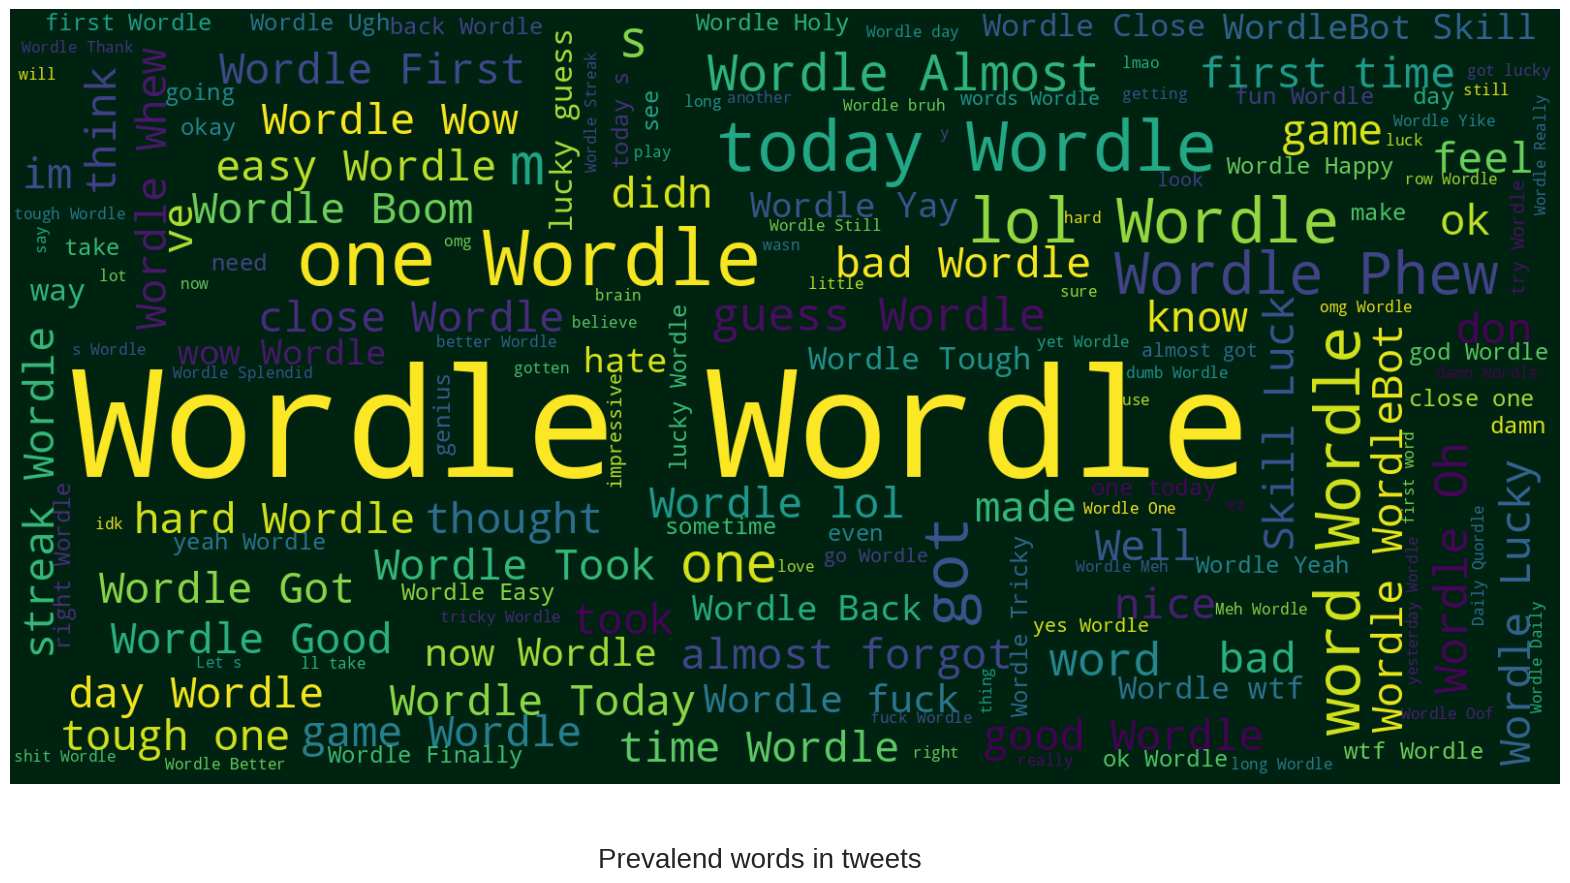

In [18]:
show_wordcloud(tw['tweet_text'] , title = 'Prevalend words in tweets')

### Hastag Analysis

In [19]:
# analysis to hastag 
def plot_features_(features, title, tw, isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(tw[feature]),kde=True,hist=False, bins=120, label=feature,color='blue')
        else:
            sns.distplot(tw[feature],kde=True, hist=False, bins=120, label=feature,color='blue')
    plt.xlabel('')
    plt.legend()
    plt.show();

### Pre Processing of Dataset

In [20]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [21]:
temp = []
#Splitting pd.Series to list
data_to_list = tw["tweet_text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Wordle 210 4/6 ⬛⬛🟨🟨⬛ 🟩⬛⬛⬛⬛ 🟩🟩🟨⬛⬛ 🟩🟩🟩🟩🟩',
 'Wordle 210 4/6 ⬜⬜⬜⬜⬜ 🟩🟩🟨🟨⬜ 🟩🟩⬜🟩🟨 🟩🟩🟩🟩🟩',
 'Wordle 210 4/6 ⬜⬜⬜🟨⬜ ⬜🟩⬜🟨⬜ ⬜🟩⬜🟨⬜ 🟩🟩🟩🟩🟩',
 'Wordle 210 3/6 ⬜⬜🟨⬜⬜ 🟨🟨⬜⬜⬜ 🟩🟩🟩🟩🟩',
 'Wordle 210 3/6 ⬛⬛🟨⬛⬛ 🟩🟩🟩⬛⬛ 🟩🟩🟩🟩🟩']

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

data_words = list(sent_to_words(temp))
print(data_words[:10],'\n')

[['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle'], ['wordle', 'got', 'lucky', 'lol'], ['wordle']] 



In [23]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['wordle', 'wordle', 'wordle', 'wordle', 'wordle']


### Sentiment Analysis

In [24]:
# make sentiment analysis positive , negative and neutral 
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [25]:
tw['sentiment'] = tw['tweet_text'].apply(lambda x: find_sentiment(x))
tw.head(10)

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,sentiment
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,Neutral
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩,Neutral
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩,Neutral
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩,Neutral
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,Neutral
5,210,1482553448025395202,2022-01-16 03:21:01+00:00,iconoco,Wordle 210 4/6\n\n⬛⬛⬛🟨⬛\n🟨🟨⬛🟨⬛\n⬛🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,Neutral
6,210,1482553451439603720,2022-01-16 03:21:01+00:00,ParickHarmon,Wordle 210 3/6\n\n🟨⬜⬜🟩⬜\n⬜🟨🟨🟨⬜\n🟩🟩🟩🟩🟩,Neutral
7,210,1482553460251709443,2022-01-16 03:21:04+00:00,Revnan2001,Wordle 210 4/6\n\n⬜⬜🟨⬜⬜\n⬜⬜⬜🟨⬜\n🟩🟨⬜⬜🟨\n🟩🟩🟩🟩🟩,Neutral
8,210,1482553474243981312,2022-01-16 03:21:07+00:00,sarajmun,Wordle 210 2/6\n\n🟨🟩⬛🟩🟨\n🟩🟩🟩🟩🟩\n\nGot lucky lol,Positive
9,210,1482553491050700800,2022-01-16 03:21:11+00:00,CraigBatts,Wordle 210 2/6\n\n⬜🟩🟨⬜⬜\n🟩🟩🟩🟩🟩,Neutral


Encoding

In [26]:
# Label Encoding
labels = np.array(tw["sentiment"])
y = []
for i in range(len(labels)):
    if labels[i] == 'Neutral':
        y.append(0)
    if labels[i] == 'Negative':
        y.append(1)
    if labels[i] == "Positive":
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [27]:
# total sentiment analysis and show plotly 

def plot_sentiment(tw, feature, title):
    counts = tw[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='red')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}\n")  
    plt.tight_layout()
    plt.show()

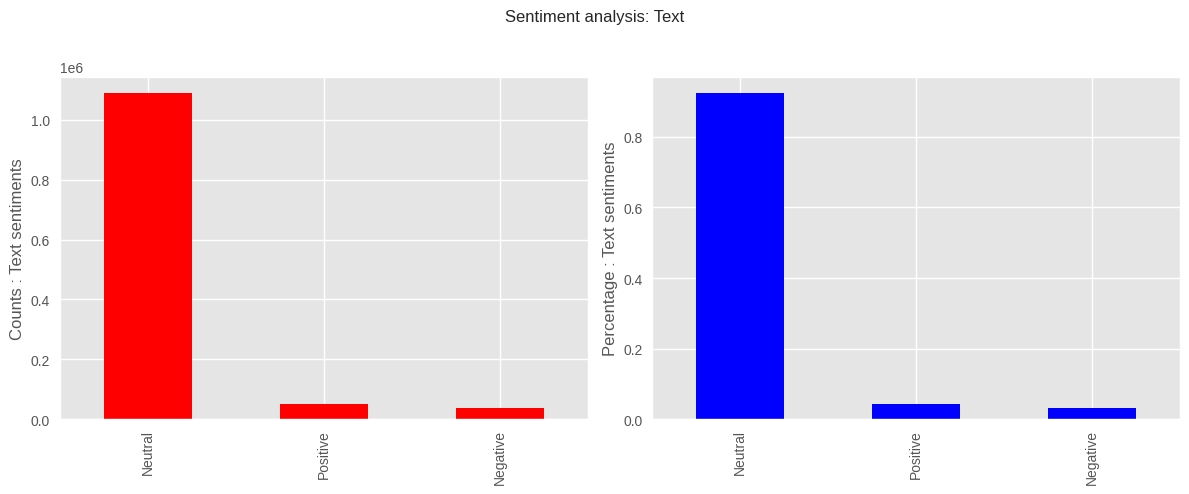

In [28]:
# visiualisiation 

plot_sentiment(tw, 'sentiment', 'Text')

### Time Series 

Tweet Time

In [29]:
tw['hour'] = pd.DatetimeIndex(tw['tweet_date']).hour
tw['date'] = pd.DatetimeIndex(tw['tweet_date']).date
tw['count'] = 1
data_filtered = tw[['hour', 'date', 'count']]
data_filtered.head(5)

,hour,date,count
0,3,2022-01-16,1
1,3,2022-01-16,1
2,3,2022-01-16,1
3,3,2022-01-16,1
4,3,2022-01-16,1


In [30]:
df_tweets_hourly = data_filtered.groupby(["hour"]).sum().reset_index()
df_tweets_hourly.head(2)
# We have 113298 tweets for oth hour

,hour,count
0,0,87478
1,1,78584


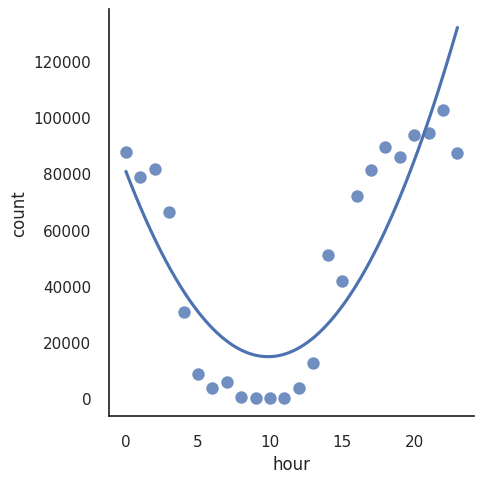

In [31]:
# Lets plot hour and count
sns.set(style="white")
sns.lmplot(x="hour", y="count",order=2, ci=None, scatter_kws={"s": 80}, data=df_tweets_hourly)


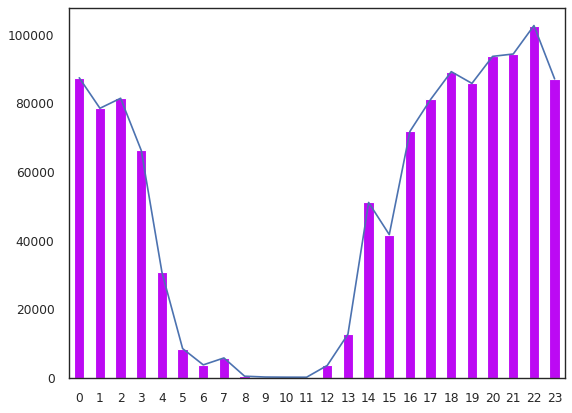

In [32]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
df_tweets_hourly["count"].plot.bar(color='#BC0AF3')
df_tweets_hourly["count"].plot()
plt.show()


<Axes: title={'center': 'Wordle Tweets by Day'}>

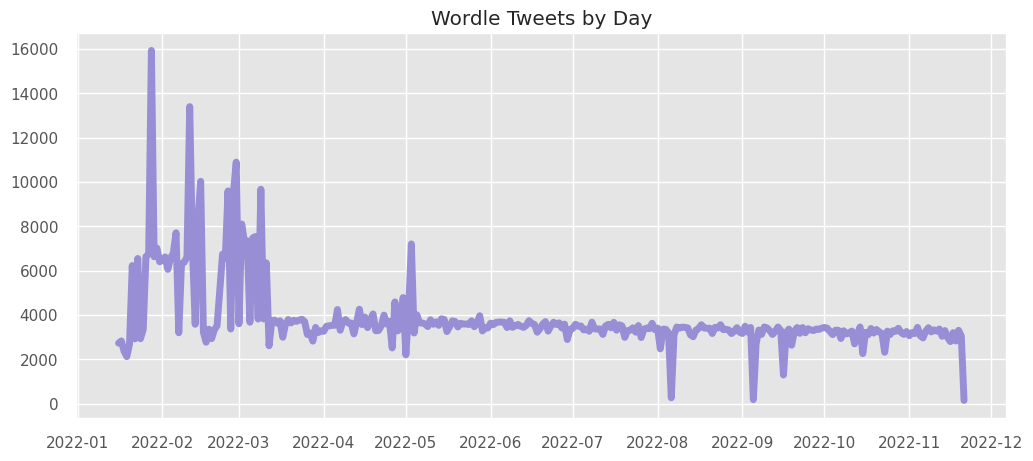

In [33]:
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
tweets = pd.read_csv('tweets_wordle.csv')
tweets['tweet_date'] = pd.to_datetime(tweets['tweet_date'])
tweets['tweet_date_'] = tweets['tweet_date'].dt.date
tweets['wordle_id'] = tweets['tweet_text'].str[:10]
tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
tweets['id'] = tweets['tweet_text'].str[7:10].astype('int')
# Doesn't look like every tweet is captured
tweets['tweet_date_'].value_counts() \
    .plot(figsize=(12, 5),
          title='Wordle Tweets by Day',
         color=color_pal[2], lw=5)

CLuster

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load the Wordle data
tw = pd.read_csv('tweets_wordle.csv')

# Extract the tweet text
tweet_text = tw['tweet_text'].tolist()

# Convert text to numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tweet_text)

# Apply K-means clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the original dataframe
tw['cluster_label'] = cluster_labels

# Print the cluster labels for each Wordle instance
for i, label in enumerate(cluster_labels):
    print(f"Wordle {tw['wordle_id'][i]} belongs to Cluster {label}")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 0
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 0
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Cluster 2
Wordle 518 belongs to Clu

LSTM

In [35]:
#Conver the word to vec
max_words = 50
max_len = 20

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 1 3]
 [0 0 0 ... 0 0 1]]


In [36]:
print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [37]:
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import train_test_split

In [38]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (f"Our data split form:\n")
print(f"X_train: ",len(X_train))
print(f"X_test: ",len(X_test))
print(f"y_train: ",len(y_train))
print(f"y_test: ", len(y_test))

Our data split form:

X_train:  883840
X_test:  294614
y_train:  883840
y_test:  294614


In [39]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history1 = model1.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint1]);

Epoch 1/5
27620/27620 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9338
Epoch 1: val_accuracy improved from -inf to 0.93733, saving model to best_model1.hdf5
27620/27620 [==============================] - 279s 10ms/step - loss: 0.2063 - accuracy: 0.9338 - val_loss: 0.1995 - val_accuracy: 0.9373
Epoch 2/5
27618/27620 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9354
Epoch 2: val_accuracy did not improve from 0.93733
27620/27620 [==============================] - 294s 11ms/step - loss: 0.2028 - accuracy: 0.9354 - val_loss: 0.1992 - val_accuracy: 0.9371
Epoch 3/5
27618/27620 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9356
Epoch 3: val_accuracy did not improve from 0.93733
27620/27620 [==============================] - 290s 11ms/step - loss: 0.2019 - accuracy: 0.9356 - val_loss: 0.1990 - val_accuracy: 0.9369
Epoch 4/5
27615/27620 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9358
Ep

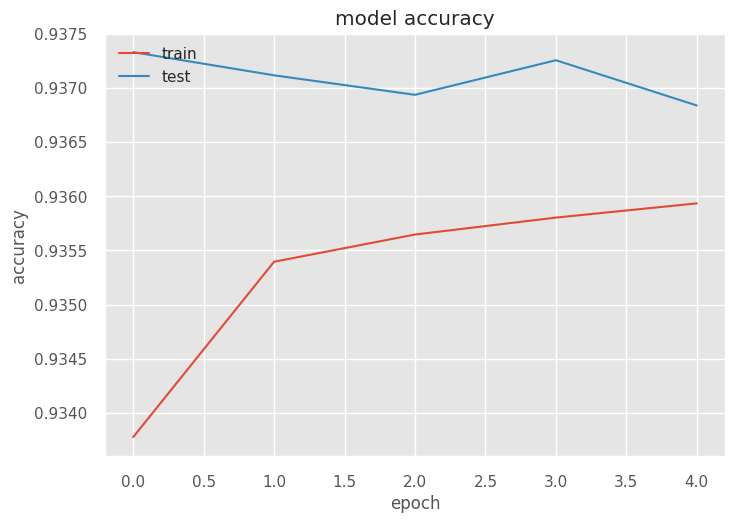

In [40]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

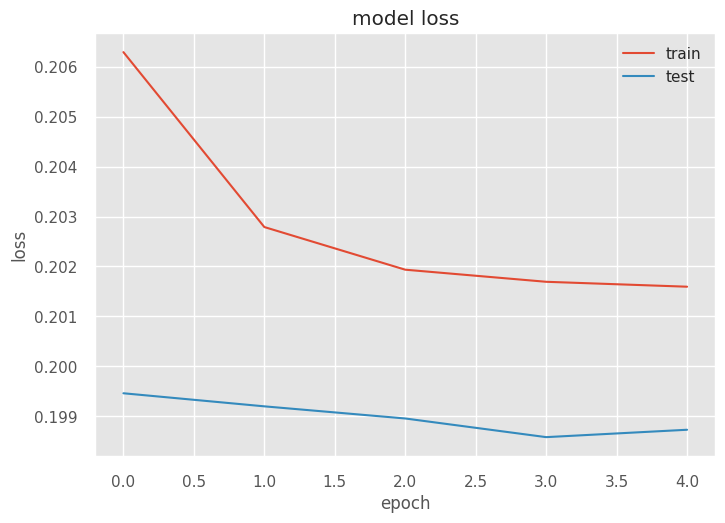

In [41]:
# summarize history for accuracy
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [42]:
# Model Evaluation 

from tensorflow import keras
best_model = keras.models.load_model("./best_model1.hdf5")

In [43]:
predictions = best_model.predict(X_test)
print(predictions)

9207/9207 [==============================] - 31s 3ms/step
[[0.9767198  0.00818512 0.01509509]
 [0.9767198  0.00818512 0.01509509]
 [0.9767198  0.00818512 0.01509509]
 ...
 [0.9767198  0.00818512 0.01509509]
 [0.9767198  0.00818512 0.01509509]
 [0.9767198  0.00818512 0.01509509]]


In [44]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

9207/9207 - 32s - loss: 0.1995 - accuracy: 0.9373 - 32s/epoch - 3ms/step
Model accuracy:  0.9373281598091125


In [45]:
# Plot the classification_report 
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1),np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    272567
           1       0.51      0.21      0.29      9276
           2       0.64      0.27      0.38     12771

    accuracy                           0.94    294614
   macro avg       0.70      0.49      0.55    294614
weighted avg       0.92      0.94      0.92    294614



Bidirectional LSTM

In [46]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Save the Modek
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# Train the Model
history = model.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/5
27618/27620 [============================>.] - ETA: 0s - loss: 0.2046 - accuracy: 0.9344
Epoch 1: val_accuracy improved from -inf to 0.93537, saving model to best_model2.hdf5
27620/27620 [==============================] - 462s 17ms/step - loss: 0.2046 - accuracy: 0.9344 - val_loss: 0.2011 - val_accuracy: 0.9354
Epoch 2/5
27620/27620 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9356
Epoch 2: val_accuracy improved from 0.93537 to 0.93723, saving model to best_model2.hdf5
27620/27620 [==============================] - 450s 16ms/step - loss: 0.2016 - accuracy: 0.9356 - val_loss: 0.1986 - val_accuracy: 0.9372
Epoch 3/5
27620/27620 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9360
Epoch 3: val_accuracy improved from 0.93723 to 0.93729, saving model to best_model2.hdf5
27620/27620 [==============================] - 454s 16ms/step - loss: 0.2014 - accuracy: 0.9360 - val_loss: 0.1981 - val_accuracy: 0.9373
Epoch 4/5
27617/27620 [==

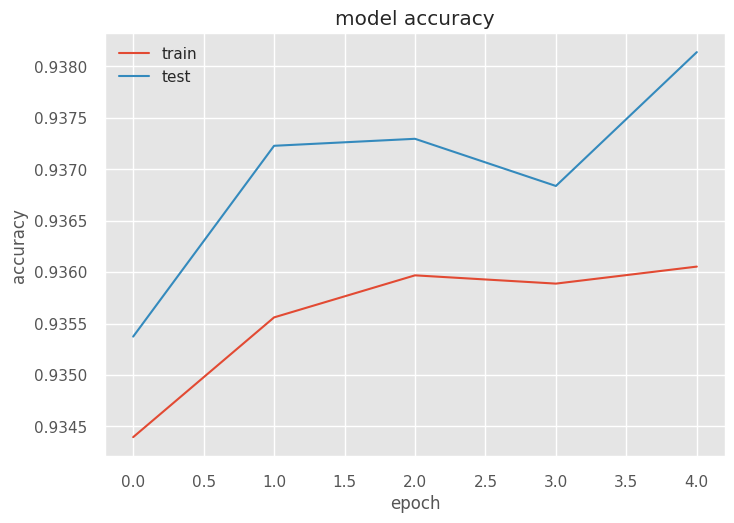

In [47]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

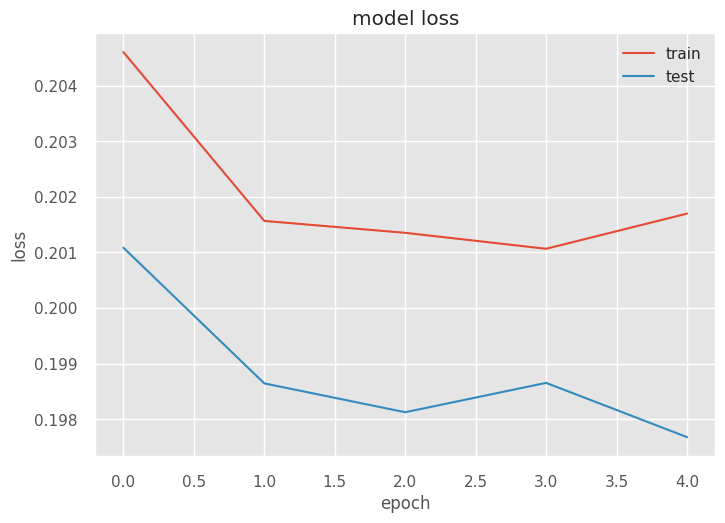

In [48]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [49]:
# Model Evaluation 

best_model = keras.models.load_model("./best_model2.hdf5")

In [50]:
predictions = best_model.predict(X_test)
print(predictions)

9207/9207 [==============================] - 51s 5ms/step
[[0.97720414 0.00806559 0.01473026]
 [0.97720414 0.00806559 0.01473026]
 [0.97720414 0.00806559 0.01473026]
 ...
 [0.9772042  0.00806559 0.01473026]
 [0.9772042  0.00806559 0.01473026]
 [0.9772042  0.00806559 0.01473026]]


In [51]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

9207/9207 - 41s - loss: 0.1977 - accuracy: 0.9381 - 41s/epoch - 4ms/step
Model accuracy:  0.9381359815597534


In [52]:
# Plot the classification_report 
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1),np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    272567
           1       0.49      0.28      0.35      9276
           2       0.65      0.28      0.39     12771

    accuracy                           0.94    294614
   macro avg       0.70      0.52      0.57    294614
weighted avg       0.92      0.94      0.93    294614



Confusion Matrix

In [53]:
from sklearn.metrics import confusion_matrix 

<Axes: >

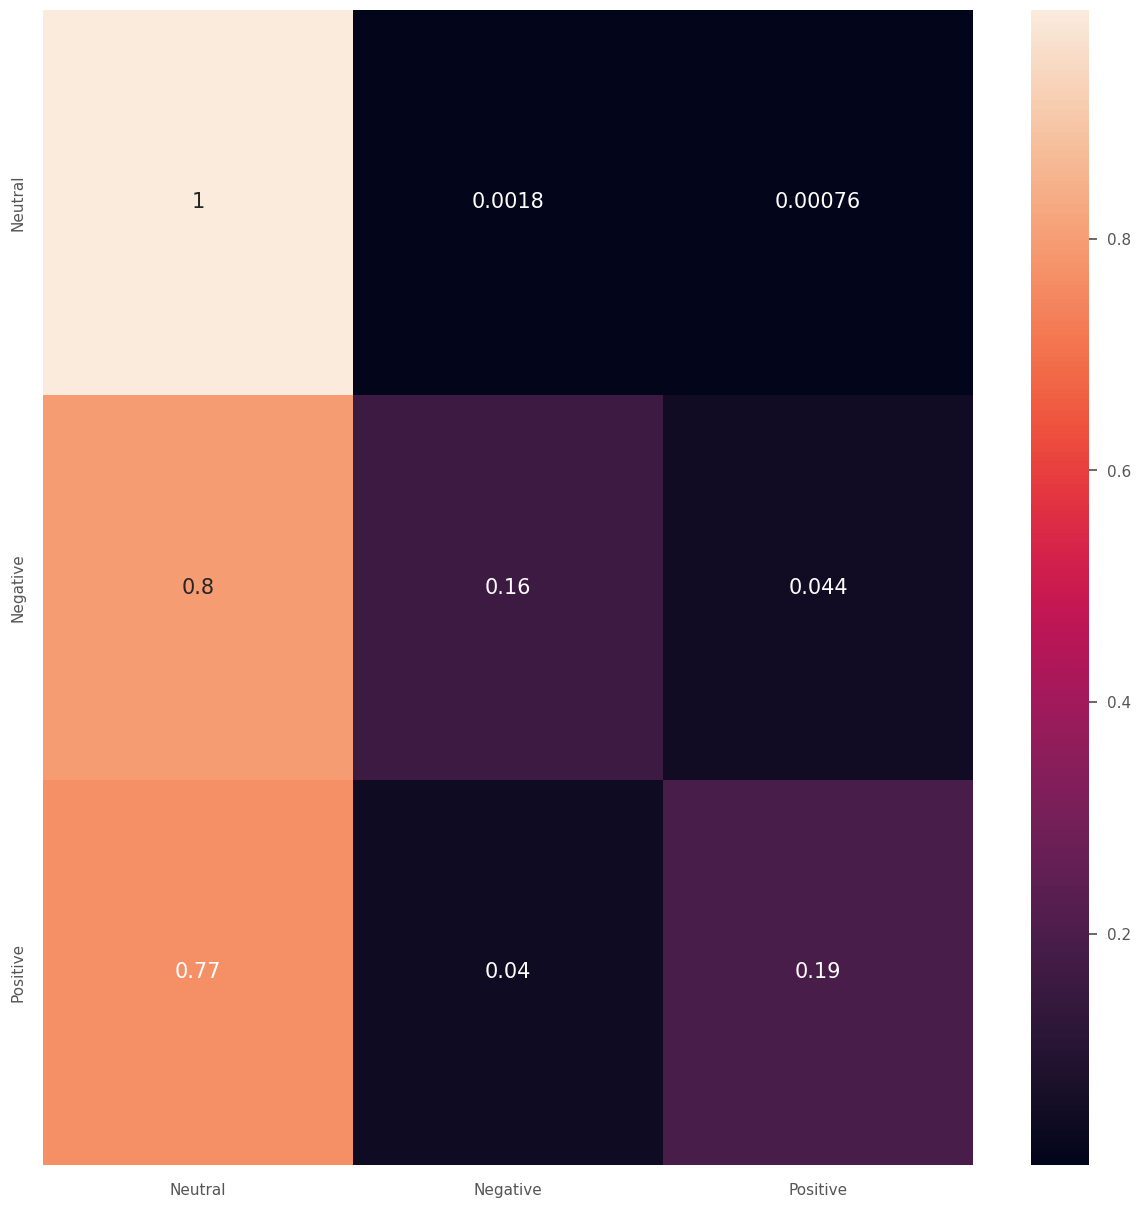

In [54]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])

#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})